# model_training_&_validation.ipynb

## Purpose
Train and validate six different classification models on the provided handwriting digit training dataset.  
Hyperparameters are tuned using training/validation procedures (5-fold stratified cross validation), and model performance is compared across all methods.

## Inputs
- **project_1_training.csv**  
  Labeled digit image data used for training and validation.

## Outputs
- Trained versions of all six classification models with selected hyperparameters  
- A comparison figure showing training/validation accuracy for all models (model_comparison_accuracy.png)
- Saved model objects (used later in model_testing.ipynb)  
- Identification of the best-performing model for final test prediction

## Import Data

In [21]:
import pandas as pd

train_df = pd.read_csv("training.csv")
print(train_df.shape)
train_df.head()

(21000, 785)


,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,7,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,7,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## inspect missingness

In [22]:
train_df.isnull().sum().sum()

# No missing values were found in the training dataset.
# All pixel features are fully observed.

np.int64(0)

## check pixel range

In [23]:
y = train_df["label"]
X = train_df.drop(columns=["label"])

print(X.min().min(), X.max().max())

# Pixel intensity values are within the expected grayscale range (0–255),
# so no additional cleaning or correction is needed.

0 255


## drop constant features 

In [24]:
import numpy as np

print("Checking for constant features...\n")

# Calculate variance of each feature
variances = X.var()

# Identify constant features (variance == 0)
constant_features = variances[variances == 0].index.tolist()

num_constant = len(constant_features)

print(f"Total features before dropping: {X.shape[1]}")
print(f"Number of constant features found: {num_constant}")

if num_constant > 0:
    print("\nDropping constant features...")
    X = X.drop(columns=constant_features)
else:
    print("\nNo constant features found.")

print(f"\nTotal features after dropping: {X.shape[1]}")
print("Done.")

Checking for constant features...

Total features before dropping: 784
Number of constant features found: 89

Dropping constant features...

Total features after dropping: 695
Done.


## kNN Training and validation

kNN Cross-Validation Sweep (NO SCALING)
Candidate k values: [1, 3, 5, 7, 9, 11]
CV strategy: StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
Distance metric: Euclidean (minkowski, p=2) [default]
Weights: distance
Preprocessing: None
Scoring metric: accuracy

[k= 1] CV accuracy = 0.9575 ± 0.0036
[k= 3] CV accuracy = 0.9597 ± 0.0025
[k= 5] CV accuracy = 0.9585 ± 0.0036
[k= 7] CV accuracy = 0.9574 ± 0.0030
[k= 9] CV accuracy = 0.9556 ± 0.0037
[k=11] CV accuracy = 0.9530 ± 0.0034

Best: k=3, CV accuracy=0.9597 ± 0.0025



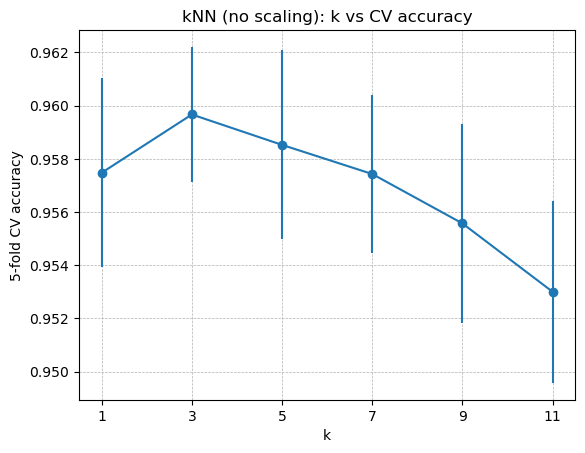

Saved model to: best_knn_model_no_scaling.joblib
Model: Pipeline(KNeighborsClassifier), k=3, weights=distance


In [25]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.base import clone
import joblib

# -----------------------------
# Settings
# -----------------------------
k_values = list(range(1, 12, 2))
cv_folds = 5
random_state = 42
use_distance_weights = True

weights_mode = "distance" if use_distance_weights else "uniform"

print("==============================================")
print("kNN Cross-Validation Sweep (NO SCALING)")
print("==============================================")
print(f"Candidate k values: {k_values}")
print(f"CV strategy: StratifiedKFold(n_splits={cv_folds}, shuffle=True, random_state={random_state})")
print("Distance metric: Euclidean (minkowski, p=2) [default]")
print(f"Weights: {weights_mode}")
print("Preprocessing: None")
print("Scoring metric: accuracy")
print("==============================================\n")

knn_pipeline_template = Pipeline([
    ("knn", KNeighborsClassifier(weights=weights_mode, n_jobs=-1))
])

cv = StratifiedKFold(n_splits=cv_folds, shuffle=True, random_state=random_state)

results = []
for k in k_values:
    model = clone(knn_pipeline_template)
    model.set_params(knn__n_neighbors=k)

    scores = cross_val_score(model, X, y, cv=cv, scoring="accuracy", n_jobs=-1)
    results.append({"k": k, "mean_acc": scores.mean(), "std_acc": scores.std()})
    print(f"[k={k:2d}] CV accuracy = {scores.mean():.4f} ± {scores.std():.4f}")

best = sorted(results, key=lambda d: (-d["mean_acc"], d["k"]))[0]
best_k = best["k"]

print(f"\nBest: k={best_k}, CV accuracy={best['mean_acc']:.4f} ± {best['std_acc']:.4f}\n")

# Plot
ks = [r["k"] for r in results]
means = [r["mean_acc"] for r in results]
stds = [r["std_acc"] for r in results]

plt.figure()
plt.errorbar(ks, means, yerr=stds, fmt="o-")
plt.xticks(ks)
plt.xlabel("k")
plt.ylabel("5-fold CV accuracy")
plt.title("kNN (no scaling): k vs CV accuracy")
plt.grid(True, which="both", linestyle="--", linewidth=0.5)
plt.show()

# Fit and save
best_model = clone(knn_pipeline_template)
best_model.set_params(knn__n_neighbors=best_k)
best_model.fit(X, y)

model_path = "best_knn_model_no_scaling.joblib"
joblib.dump(best_model, model_path)

print(f"Saved model to: {model_path}")
print(f"Model: Pipeline(KNeighborsClassifier), k={best_k}, weights={weights_mode}")